In [1]:
import sys
sys.executable

'/home/sh0416/anaconda3/envs/sentence-benchmark/bin/python'

In [2]:
import os
rootpath = os.path.abspath(os.path.join(os.getcwd(), os.path.pardir, os.path.pardir))

In [3]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(rootpath, "src")))
sys.path

['/home/sh0416/sentence-benchmark/src/notebooks',
 '/home/sh0416/anaconda3/envs/sentence-benchmark/lib/python38.zip',
 '/home/sh0416/anaconda3/envs/sentence-benchmark/lib/python3.8',
 '/home/sh0416/anaconda3/envs/sentence-benchmark/lib/python3.8/lib-dynload',
 '',
 '/home/sh0416/anaconda3/envs/sentence-benchmark/lib/python3.8/site-packages',
 '/home/sh0416/anaconda3/envs/sentence-benchmark/lib/python3.8/site-packages/IPython/extensions',
 '/home/sh0416/.ipython',
 '/home/sh0416/sentence-benchmark/src']

In [14]:
from transformers import RobertaModel
#model = RobertaModel.from_pretrained("roberta-base")
model = RobertaModel.from_pretrained("princeton-nlp/unsup-simcse-roberta-base")
model.eval()

RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(50265, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0): RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dropout): Drop

In [15]:
from transformers import RobertaTokenizer
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

In [16]:
from sentence_benchmark.data import load_sts12

In [17]:
sts12 = load_sts12(os.path.join(rootpath, "data/STS/STS12-en-test"))

In [18]:
import random
random.seed(0)
pos_example = sorted(list(filter(lambda x: x.score > 4, sts12["MSRpar"])), key=lambda x: len(x.input[0]))[0]
neg_example = sorted(list(filter(lambda x: x.score < 2, sts12["MSRpar"])), key=lambda x: len(x.input[0]))[0]

In [19]:
def get_inputs_and_outputs(example):
    inputs = tokenizer(example.input, padding=True, return_tensors='pt')
    outputs = model(**inputs)
    return inputs, outputs

pos_inputs, pos_outputs = get_inputs_and_outputs(pos_example)
neg_inputs, neg_outputs = get_inputs_and_outputs(neg_example)

In [20]:
import torch
import torch.nn.functional as F

def get_pairwise_sim(example, inputs, outputs):
    last_hidden_state1 = outputs.last_hidden_state[0]
    last_hidden_state2 = outputs.last_hidden_state[1]
    pairwise_sim = F.cosine_similarity(last_hidden_state1[:, None, :], last_hidden_state2[None, :, :], dim=2)
    
    attention_mask1 = inputs.attention_mask[0]
    attention_mask2 = inputs.attention_mask[1]
    pairwise_valid = torch.logical_and(attention_mask1[:, None], attention_mask2[None, :])

    input_length1 = attention_mask1.count_nonzero()
    input_length2 = attention_mask2.count_nonzero()
    pairwise_valid_sim = torch.masked_select(pairwise_sim, pairwise_valid).view(input_length1, input_length2)
    return pairwise_valid_sim

pos_pairwise_sim = get_pairwise_sim(pos_example, pos_inputs, pos_outputs)
neg_pairwise_sim = get_pairwise_sim(neg_example, neg_inputs, neg_outputs)

In [21]:
def get_input_strs(inputs):
    input_strs1 = list(filter(lambda x: x != "<pad>", tokenizer.convert_ids_to_tokens(inputs.input_ids[0])))
    input_strs2 = list(filter(lambda x: x != "<pad>", tokenizer.convert_ids_to_tokens(inputs.input_ids[1])))
    return input_strs1, input_strs2

pos_input_strs1, pos_input_strs2 = get_input_strs(pos_inputs)
neg_input_strs1, neg_input_strs2 = get_input_strs(neg_inputs)

In [22]:
pos_sentence1, pos_sentence2 = tokenizer.batch_decode(pos_inputs.input_ids)
neg_sentence1, neg_sentence2 = tokenizer.batch_decode(neg_inputs.input_ids)

<s>moore had no immediate comment tuesday.</s><pad><pad>
<s>moore did not have an immediate response tuesday.</s>


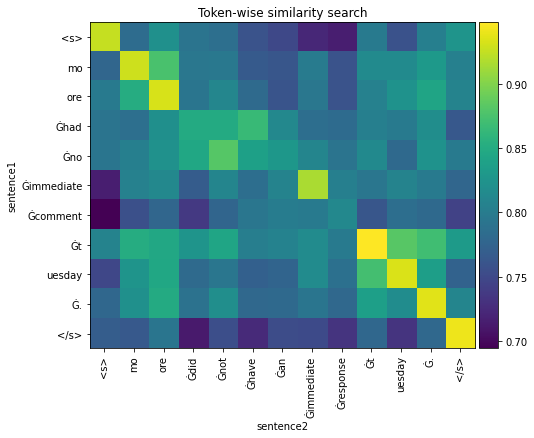

<s>in the united states, 20.7 percent of all women smoke.</s>
<s>nevada is where the most women smoke, 28 percent.</s><pad>


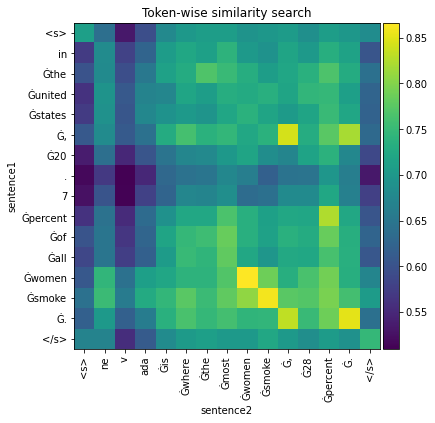

In [23]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot(pairwise_sim, input_strs1, input_strs2):
    fig, ax = plt.subplots(figsize=(12, 6))
    fig.patch.set_facecolor("#ffffff")
    ax.set_title("Token-wise similarity search")
    ax.set_ylabel("sentence1")
    ax.set_xlabel("sentence2")
    ax.set_yticks(range(len(input_strs1)))
    ax.set_yticklabels(input_strs1)
    ax.set_xticks(range(len(input_strs2)))
    ax.set_xticklabels(input_strs2, rotation=90)
    im = ax.imshow(pairwise_sim.detach().numpy())
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    plt.show()

print(pos_sentence1)
print(pos_sentence2)
plot(pos_pairwise_sim, pos_input_strs1, pos_input_strs2)
print(neg_sentence1)
print(neg_sentence2)
plot(neg_pairwise_sim, neg_input_strs1, neg_input_strs2)